# Covid-19 Monitoring Notebook 
The Johns Hopkins Center for Systems Science and Engineering (CSSE) operates a [dashboard](https://systems.jhu.edu/research/public-health/ncov/) on the Web to follow the covid-19 cases and deaths all over the world. The data is collected on a daily basis from different sources and has been made available on [Github](https://github.com/CSSEGISandData/COVID-19). This is a selection for some European countries. The observed cases are shown for each country and then merged together for comparison.

[Italy](#Italy)  
[Germany](#Germany)  
[France](#France)  
[Spain](#Spain)  
[Comparisons](#Comparisons)

***
## Definitions and references
We follow the definitions for measures as given in the book by Bonita et al., [Basic Epidemiology, 2nd ed.](https://apps.who.int/iris/handle/10665/43541) available in different languages from the World Health Organization website.  
* ***Cumulative Incidence*** is the number of new cases of the disease during a specified period of time in a specific healthy population. It represents the risk of becoming ill. In this notebook the period of time considered is from the onset of the disease  up to the last update report and the population at risk is the entire population of a country. The cumulative incidence is computed as the ratio between the cumulative confirmed infections and the country's population, assuming that a vast majority is still healthy, per 1000 people (see Bonita et al., p.21).
* ***Case fatality*** represents the ratio between the number of people who have died from the infection and the number of people who have been confirmed to be infected, expressed as a percentage. In this notebook it is computed as the ratio between the cumulative confirmed infections and the cumulative deaths (see Bonita et al., p.22).

Other articles or publications
* [Report of the WHO-China Joint Mission on Coronavirus Disease 2019 (COVID-19)](https://www.who.int/docs/default-source/coronaviruse/who-china-joint-mission-on-covid-19-final-report.pdf)
* [Adjusted age-specific case fatality ratio during the COVID-19 epidemic in Hubei, China, January and February 2020](https://www.medrxiv.org/content/10.1101/2020.03.04.20031104v1)

## Software 
This notebook uses python as programming language, and some libraries, pandas for data handling and matplotlib for data visualization. The covid-19 data is handled as pandas time series and is visualized as simple line plot with the dates as x dimension and the observation as y dimension. Bar charts cannot use directly pandas' time series objects so two separated arrays are created from the time series to be used as input for bar charts, days and observations. The solution used may change if better libraries are discovered.

<a href="https://colab.research.google.com/github/luigiselmi/datascience/blob/master/python/covid19-monitoring-notebook.ipynb" target="_blank"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" width="117" height="20"></a>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
import seaborn; seaborn.set()
import warnings
#warnings.filterwarnings('ignore')
from platform import python_version
print("python version: %s"%python_version())
print("numpy version: %s"%np.__version__)
print("pandas version: %s"%pd.__version__)

python version: 3.7.4
numpy version: 1.16.5
pandas version: 0.25.1


***
## Data sources

### Johns Hopkins CSSE - Covid-19 Epidemiological data 

In [2]:
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
confirmed_dataset = pd.read_csv(url_confirmed) 
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
deaths_dataset = pd.read_csv(url_deaths)
# creates an index of dates
start_date_index = 14 # starts from February 1st
dates_array = [date for date in confirmed_dataset.columns[start_date_index:]] # removes first columns that are not dates
dates_index = pd.to_datetime(dates_array)

### Eurostat population data

In [3]:
url_population = "https://raw.githubusercontent.com/luigiselmi/datascience/master/data/eurostat_population_by_age_2019.csv"
population = pd.read_csv(url_population)

### Eurostat health care facilities
Number of available beds (2017)

In [4]:
url_beds = "https://raw.githubusercontent.com/luigiselmi/datascience/master/data/eurostat_hlth_rs_bds.csv"
beds = pd.read_csv(url_beds)

***
## Italy

In [5]:
population_it = population[population['country_code'] == 'IT']['total'].values
print("Italy's population (2019) = %d"%population_it)

Italy's population (2019) = 60359546


In [6]:
beds_it = beds[beds['country_code'] == 'IT']['2017'].values
print("Italy's public and private health care facilities, available beds in 2017 = %d"%beds_it)

Italy's public and private health care facilities, available beds in 2017 = 192548


In [7]:
people_per_bed_it =  population_it / beds_it 
print("Number of persons per bed = %.0f"%people_per_bed_it)

Number of persons per bed = 313


### Cumulative confirmed infections
The number of infected individuals each day is the sum of all the confirmed infected individuals from the beginning up to that day.

In [8]:
confirmed_dataset_it = confirmed_dataset[confirmed_dataset['Country/Region'] == 'Italy'] 
confirmed_dataset_values_it = [confirmed for confirmed in confirmed_dataset_it.values[0][start_date_index:]] 
confirmed_infections_it = pd.Series(confirmed_dataset_values_it, index=dates_index)
confirmed_infections_it['2020-03-05':] 

2020-03-05     3858
2020-03-06     4636
2020-03-07     5883
2020-03-08     7375
2020-03-09     9172
2020-03-10    10149
2020-03-11    12462
2020-03-12    12462
2020-03-13    17660
2020-03-14    21157
2020-03-15    24747
2020-03-16    27980
dtype: int64

### Confirmed infections per day
The confirmed infections per day are computed from the cumulative confirmed infections by computing the difference between two consecutive days.

In [9]:
confirmed_per_day_array_it = [confirmed_infections_it[d++1] - confirmed_infections_it[d] for d in range(dates_index.size - 1)]
confirmed_per_day_it = pd.Series(confirmed_per_day_array_it, index=dates_index[1:])
confirmed_per_day_it['2020-03-05':]

2020-03-05     769
2020-03-06     778
2020-03-07    1247
2020-03-08    1492
2020-03-09    1797
2020-03-10     977
2020-03-11    2313
2020-03-12       0
2020-03-13    5198
2020-03-14    3497
2020-03-15    3590
2020-03-16    3233
dtype: int64

In [10]:
# resize the default plot
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

<BarContainer object of 44 artists>

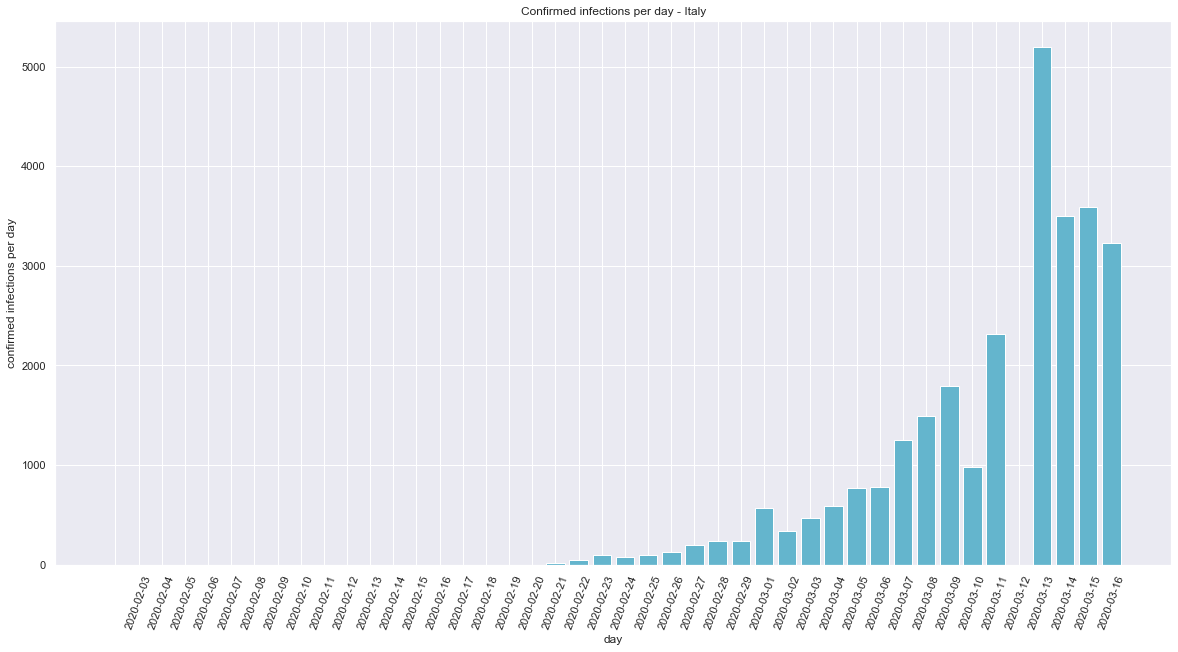

In [12]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Italy")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(confirmed_per_day_it.index)
ax.set_xticklabels(confirmed_per_day_it.index[1:].format('%Y-%m-%d'), rotation=70)
plt.bar(dates_array[1:], confirmed_per_day_array_it, color='c')

### Cumulative deaths
The number of deaths each day is the sum of the deaths from the beginning up to that day.

In [13]:
deaths_dataset_it = deaths_dataset[deaths_dataset['Country/Region'] == 'Italy']
deaths_dataset_values_it = [death for death in deaths_dataset_it.values[0][start_date_index:]]
deaths_it = pd.Series(deaths_dataset_values_it, index=dates_index)
deaths_it['2020-03-05':]

2020-03-05     148
2020-03-06     197
2020-03-07     233
2020-03-08     366
2020-03-09     463
2020-03-10     631
2020-03-11     827
2020-03-12     827
2020-03-13    1266
2020-03-14    1441
2020-03-15    1809
2020-03-16    2158
dtype: int64

### Deaths per day
The deaths per day are computed from the cumulative deaths by computing the difference between two consecutive days.

In [14]:
deaths_per_day_array_it = [deaths_it[d++1] - deaths_it[d] for d in range(dates_index.size - 1)]
deaths_per_day_it = pd.Series(deaths_per_day_array_it, index=dates_index[1:])
deaths_per_day_it['2020-03-05':]

2020-03-05     41
2020-03-06     49
2020-03-07     36
2020-03-08    133
2020-03-09     97
2020-03-10    168
2020-03-11    196
2020-03-12      0
2020-03-13    439
2020-03-14    175
2020-03-15    368
2020-03-16    349
dtype: int64

<BarContainer object of 44 artists>

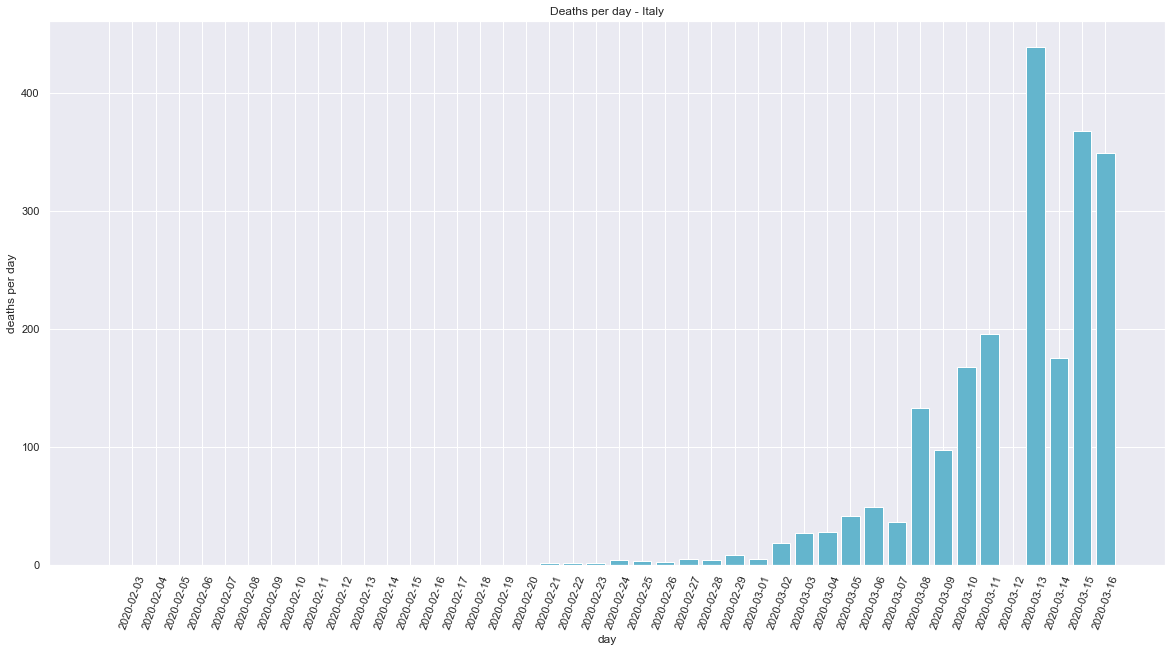

In [15]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Deaths per day - Italy")
ax.set_xlabel("day")
ax.set_ylabel("deaths per day");
ax.set_xticks(deaths_per_day_it.index)
ax.set_xticklabels(deaths_per_day_it.index[1:].format('%Y-%m-%d'), rotation=70)
plt.bar(dates_array[1:], deaths_per_day_array_it, color='c')

### Cumulative incidence

In [16]:
cumulative_incidence_it = (confirmed_infections_it[confirmed_infections_it.size - 1] / population_it) * 1000
print("Italy's cumulative incidence = %.2f"%cumulative_incidence_it)

Italy's cumulative incidence = 0.46


### Case fatality

In [17]:
last_infections_it = confirmed_infections_it[confirmed_infections_it.size - 1]
last_deaths_it = deaths_it[deaths_it.size - 1]
last_day = dates_index[dates_index.size - 1]
last_case_fatality_it = (last_deaths_it / last_infections_it) * 100 
print("Last report day: {0:4s} \ndeaths: {1:5d}; cumulative confirmed infections: {2:5d}; case fatality {3:5.2f} %".format(last_day.strftime('%Y-%m-%d'), last_deaths_it, last_infections_it, last_case_fatality_it))  

Last report day: 2020-03-16 
deaths:  2158; cumulative confirmed infections: 27980; case fatality  7.71 %


In [18]:
cf_array_it = [(deaths_it[d] / confirmed_infections_it[d]) * 100 for d in range(dates_index.size)]
cf_it = pd.Series(cf_array_it, index=dates_index)

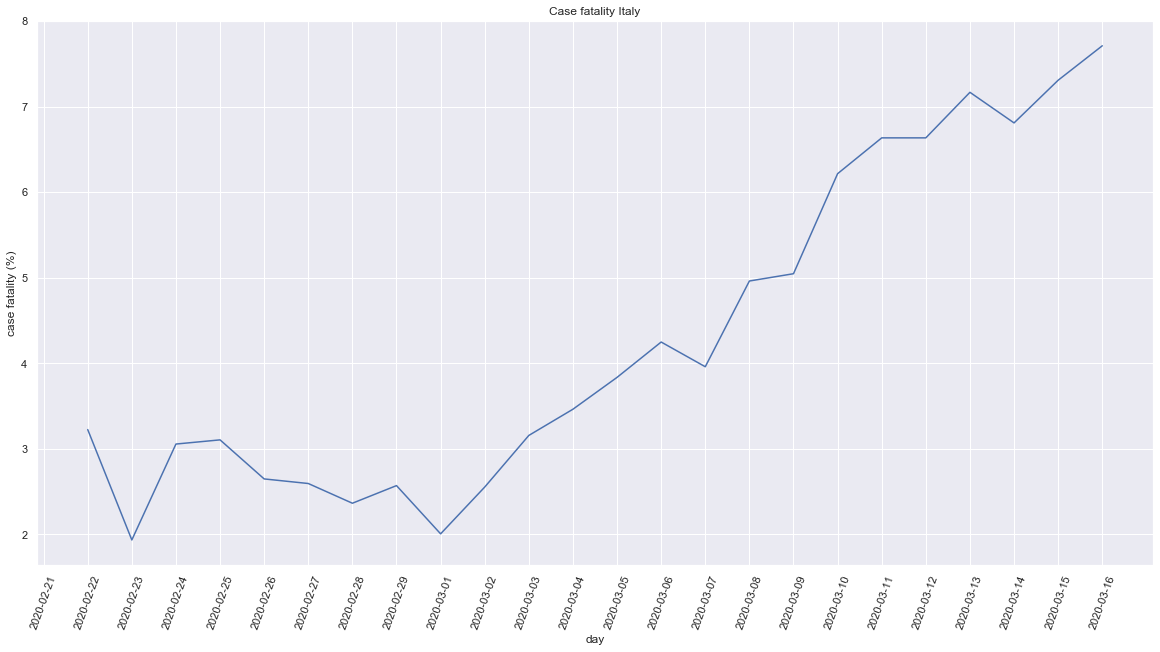

In [19]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Case fatality Italy")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(cf_it.index)
ax.set_xticklabels(cf_it.index[1:].format('%Y-%m-%d'), rotation=70)
plt.plot(cf_it['2020-02-22':])

***
## Germany

In [20]:
population_de = population[population['country_code'] == 'DE']['total'].values
print("Germany's population (2019) = %d"%population_de)

Germany's population (2019) = 83019213


In [21]:
beds_de = beds[beds['country_code'] == 'DE']['2017'].values
print("Germany's public and private health care facilities, available beds in 2017 = %d"%beds_de)

Germany's public and private health care facilities, available beds in 2017 = 661448


In [22]:
people_per_bed_de =  population_de / beds_de 
print("Number of persons per bed = %.0f"%people_per_bed_de)

Number of persons per bed = 126


### Cumulative confirmed infections
The number of infected individuals each day is the sum of all the confirmed infected individuals from the beginning up to that day.

In [23]:
confirmed_dataset_de = confirmed_dataset[confirmed_dataset['Country/Region'] == 'Germany'] 
confirmed_dataset_values_de = [confirmed for confirmed in confirmed_dataset_de.values[0][start_date_index:]] 
confirmed_infections_de = pd.Series(confirmed_dataset_values_de, index=dates_index)
confirmed_infections_de['2020-03-05':] 

2020-03-05     482
2020-03-06     670
2020-03-07     799
2020-03-08    1040
2020-03-09    1176
2020-03-10    1457
2020-03-11    1908
2020-03-12    2078
2020-03-13    3675
2020-03-14    4585
2020-03-15    5795
2020-03-16    7272
dtype: int64

### Confirmed infections per day
The confirmed infections per day are computed from the cumulative confirmed infections by computing the difference between two consecutive days.

In [24]:
confirmed_per_day_array_de = [confirmed_infections_de[d++1] - confirmed_infections_de[d] for d in range(dates_index.size - 1)]
confirmed_per_day_de = pd.Series(confirmed_per_day_array_de, index=dates_index[1:])
confirmed_per_day_de['2020-03-05':]

2020-03-05     220
2020-03-06     188
2020-03-07     129
2020-03-08     241
2020-03-09     136
2020-03-10     281
2020-03-11     451
2020-03-12     170
2020-03-13    1597
2020-03-14     910
2020-03-15    1210
2020-03-16    1477
dtype: int64

<BarContainer object of 44 artists>

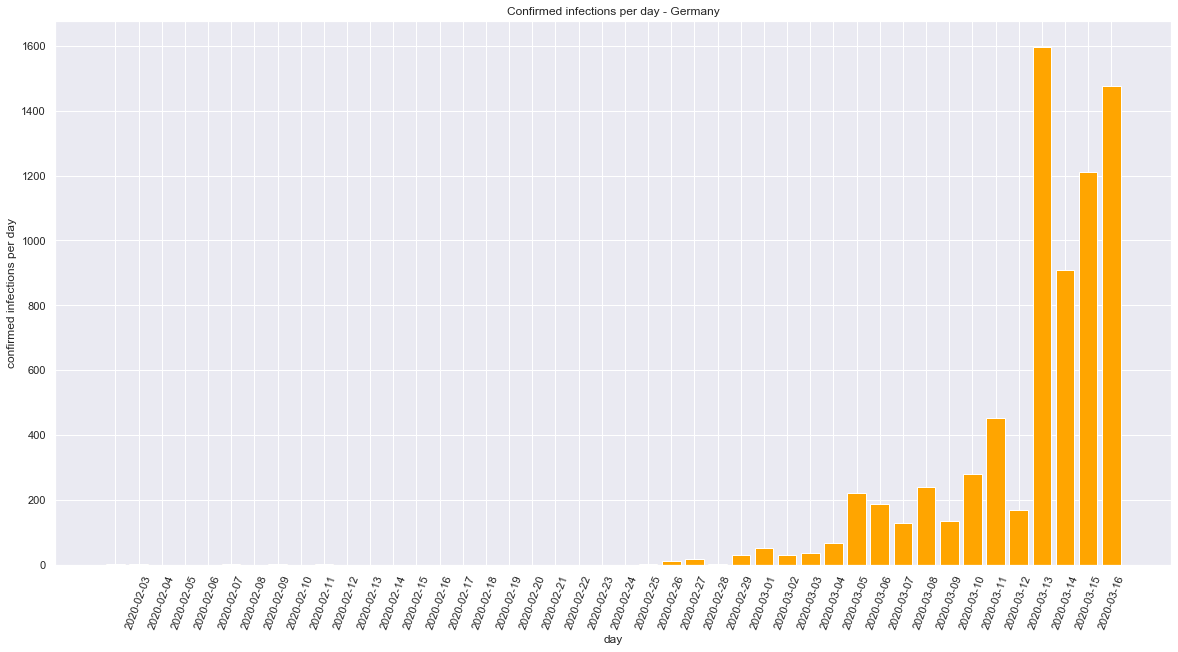

In [25]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Germany")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(confirmed_per_day_de.index)
ax.set_xticklabels(confirmed_per_day_de.index[1:].format('%Y-%m-%d'), rotation=70)
plt.bar(dates_array[1:], confirmed_per_day_array_de, color='orange')

### Cumulative deaths
The number of deaths each day is the sum of the deaths from the beginning up to that day.

In [26]:
deaths_dataset_de = deaths_dataset[deaths_dataset['Country/Region'] == 'Germany']
deaths_dataset_values_de = [death for death in deaths_dataset_de.values[0][start_date_index:]]
deaths_de = pd.Series(deaths_dataset_values_de, index=dates_index)
deaths_de['2020-03-05':]

2020-03-05     0
2020-03-06     0
2020-03-07     0
2020-03-08     0
2020-03-09     2
2020-03-10     2
2020-03-11     3
2020-03-12     3
2020-03-13     7
2020-03-14     9
2020-03-15    11
2020-03-16    17
dtype: int64

### Deaths per day
The deaths per day are computed from the cumulative deaths by computing the difference between two consecutive days.

In [27]:
deaths_per_day_array_de = [deaths_de[d++1] - deaths_de[d] for d in range(dates_index.size - 1)]
deaths_per_day_de = pd.Series(deaths_per_day_array_de, index=dates_index[1:])
deaths_per_day_de['2020-03-05':]

2020-03-05    0
2020-03-06    0
2020-03-07    0
2020-03-08    0
2020-03-09    2
2020-03-10    0
2020-03-11    1
2020-03-12    0
2020-03-13    4
2020-03-14    2
2020-03-15    2
2020-03-16    6
dtype: int64

<BarContainer object of 44 artists>

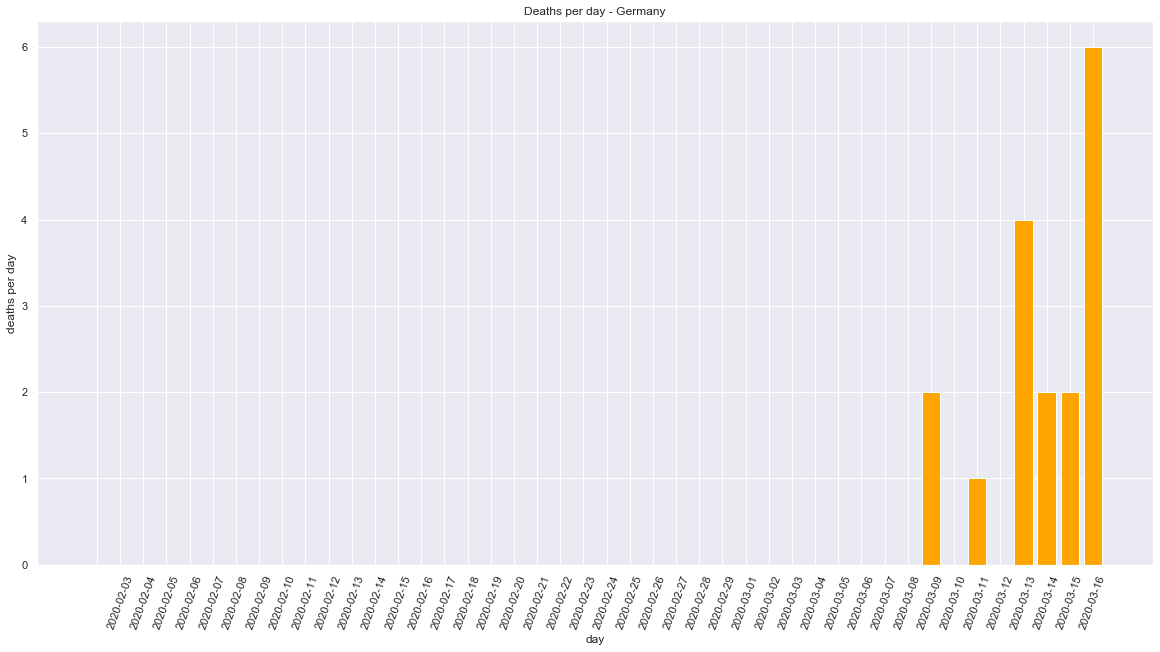

In [28]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Deaths per day - Germany")
ax.set_xlabel("day")
ax.set_ylabel("deaths per day");
ax.set_xticks(deaths_per_day_de.index)
ax.set_xticklabels(deaths_per_day_de.index[1:].format('%Y-%m-%d'), rotation=70)
plt.bar(dates_array[1:], deaths_per_day_array_de, color='orange')

### Cumulative incidence

In [29]:
cumulative_incidence_de = ( confirmed_infections_de.last('1D') / population_de) * 1000
print("Germany's cumulative incidence = %.2f"%cumulative_incidence_de)

Germany's cumulative incidence = 0.09


### Case fatality

In [30]:
last_infections_de = confirmed_infections_de[confirmed_infections_de.size - 1]
last_deaths_de = deaths_de[deaths_de.size - 1]
last_case_fatality_de = (last_deaths_de / last_infections_de) * 100 
print("Last report day: {0:4s} \ndeaths: {1:5d}; cumulative confirmed infections: {2:5d}; case fatality {3:5.2f} %".format(last_day.strftime('%Y-%m-%d'), last_deaths_de, last_infections_de, last_case_fatality_de))  

Last report day: 2020-03-16 
deaths:    17; cumulative confirmed infections:  7272; case fatality  0.23 %


In [31]:
cf_array_de = [(deaths_de[d] / confirmed_infections_de[d]) * 100 for d in range(dates_index.size)]
cf_de = pd.Series(cf_array_de, index=dates_index)

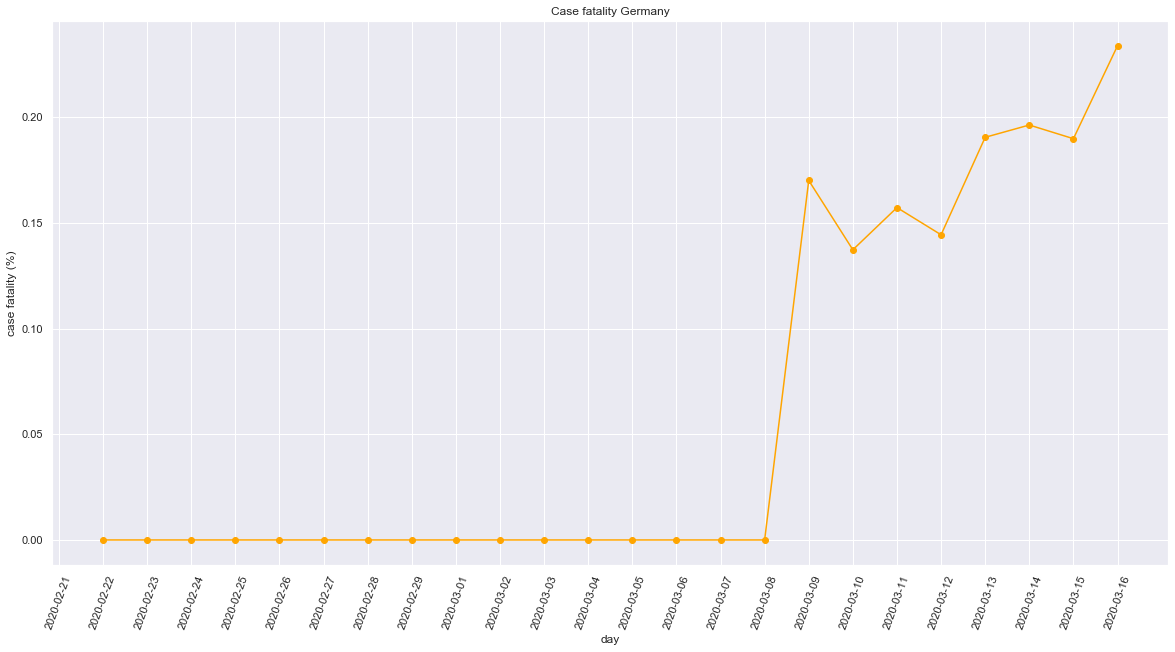

In [32]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Case fatality Germany")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(cf_de.index)
ax.set_xticklabels(cf_de.index[1:].format('%Y-%m-%d'), rotation=70)
plt.plot(cf_de['2020-02-22':], color='orange', marker='o')

***
## France

In [33]:
population_fr = population[population['country_code'] == 'FR']['total'].values
print("France's population (2019) = %d"%population_fr)

France's population (2019) = 67012883


In [34]:
beds_fr = beds[beds['country_code'] == 'FR']['2017'].values
print("France's public and private health care facilities, available beds in 2017 = %d"%beds_fr)

France's public and private health care facilities, available beds in 2017 = 399865


In [35]:
people_per_bed_fr =  population_fr / beds_fr 
print("Number of persons per bed = %.0f"%people_per_bed_fr)

Number of persons per bed = 168


### Cumulative confirmed infections
The number of infected individuals each day is the sum of all the confirmed infected individuals from the beginning up to that day.

In [36]:
confirmed_dataset_fr = confirmed_dataset[confirmed_dataset['Province/State'] == 'France'] 
confirmed_dataset_values_fr = [confirmed for confirmed in confirmed_dataset_fr.values[0][start_date_index:]] 
confirmed_infections_fr = pd.Series(confirmed_dataset_values_fr, index=dates_index)
confirmed_infections_fr['2020-03-05':] 

2020-03-05     377
2020-03-06     653
2020-03-07     949
2020-03-08    1126
2020-03-09    1209
2020-03-10    1784
2020-03-11    2281
2020-03-12    2281
2020-03-13    3661
2020-03-14    4469
2020-03-15    4499
2020-03-16    6633
dtype: int64

### Confirmed infections per day
The confirmed infections per day are computed from the cumulative confirmed infections by computing the difference between two consecutive days.

In [37]:
confirmed_per_day_array_fr = [confirmed_infections_fr[d++1] - confirmed_infections_fr[d] for d in range(dates_index.size - 1)]
confirmed_per_day_fr = pd.Series(confirmed_per_day_array_fr, index=dates_index[1:])
confirmed_per_day_fr['2020-03-05':]

2020-03-05      92
2020-03-06     276
2020-03-07     296
2020-03-08     177
2020-03-09      83
2020-03-10     575
2020-03-11     497
2020-03-12       0
2020-03-13    1380
2020-03-14     808
2020-03-15      30
2020-03-16    2134
dtype: int64

<BarContainer object of 44 artists>

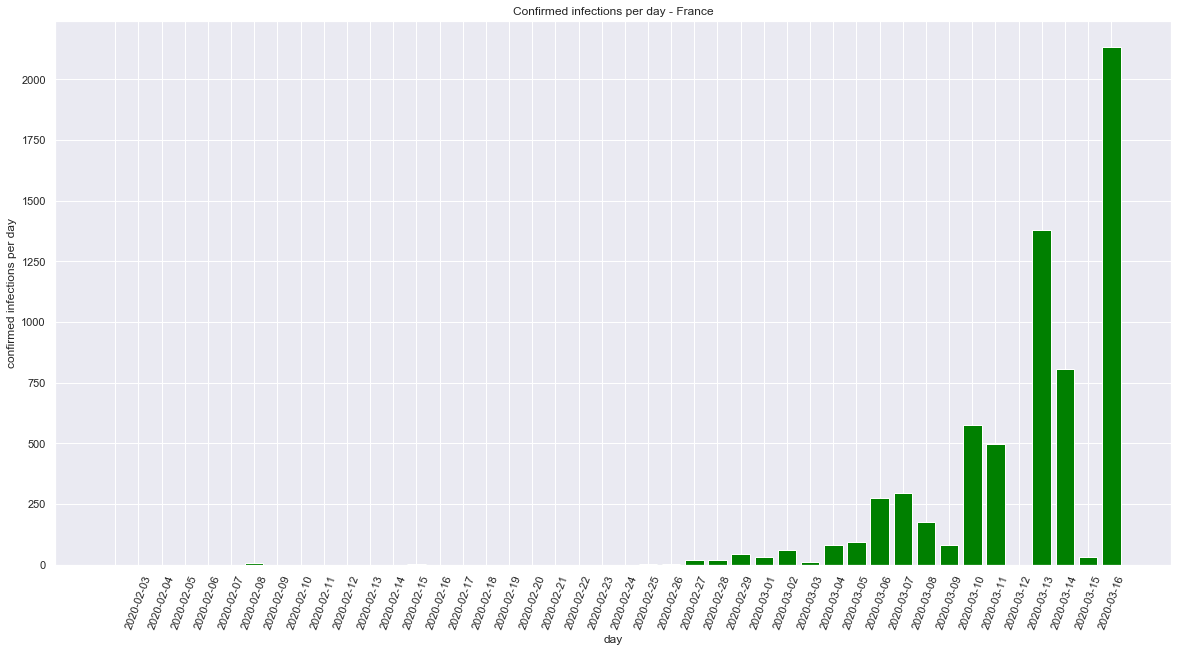

In [38]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - France")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(confirmed_per_day_fr.index)
ax.set_xticklabels(confirmed_per_day_fr.index[1:].format('%Y-%m-%d'), rotation=70)
plt.bar(dates_array[1:], confirmed_per_day_array_fr, color='green')

### Cumulative deaths
The number of deaths each day is the sum of the deaths from the beginning up to that day.

In [39]:
deaths_dataset_fr = deaths_dataset[deaths_dataset['Province/State'] == 'France']
deaths_dataset_values_fr = [death for death in deaths_dataset_fr.values[0][start_date_index:]]
deaths_fr = pd.Series(deaths_dataset_values_fr, index=dates_index)
deaths_fr['2020-03-05':]

2020-03-05      6
2020-03-06      9
2020-03-07     11
2020-03-08     19
2020-03-09     19
2020-03-10     33
2020-03-11     48
2020-03-12     48
2020-03-13     79
2020-03-14     91
2020-03-15     91
2020-03-16    148
dtype: int64

### Deaths per day
The deaths per day are computed from the cumulative deaths by computing the difference between two consecutive days.

In [40]:
deaths_per_day_array_fr = [deaths_fr[d++1] - deaths_fr[d] for d in range(dates_index.size - 1)]
deaths_per_day_fr = pd.Series(deaths_per_day_array_fr, index=dates_index[1:])
deaths_per_day_fr['2020-03-05':]

2020-03-05     2
2020-03-06     3
2020-03-07     2
2020-03-08     8
2020-03-09     0
2020-03-10    14
2020-03-11    15
2020-03-12     0
2020-03-13    31
2020-03-14    12
2020-03-15     0
2020-03-16    57
dtype: int64

<BarContainer object of 44 artists>

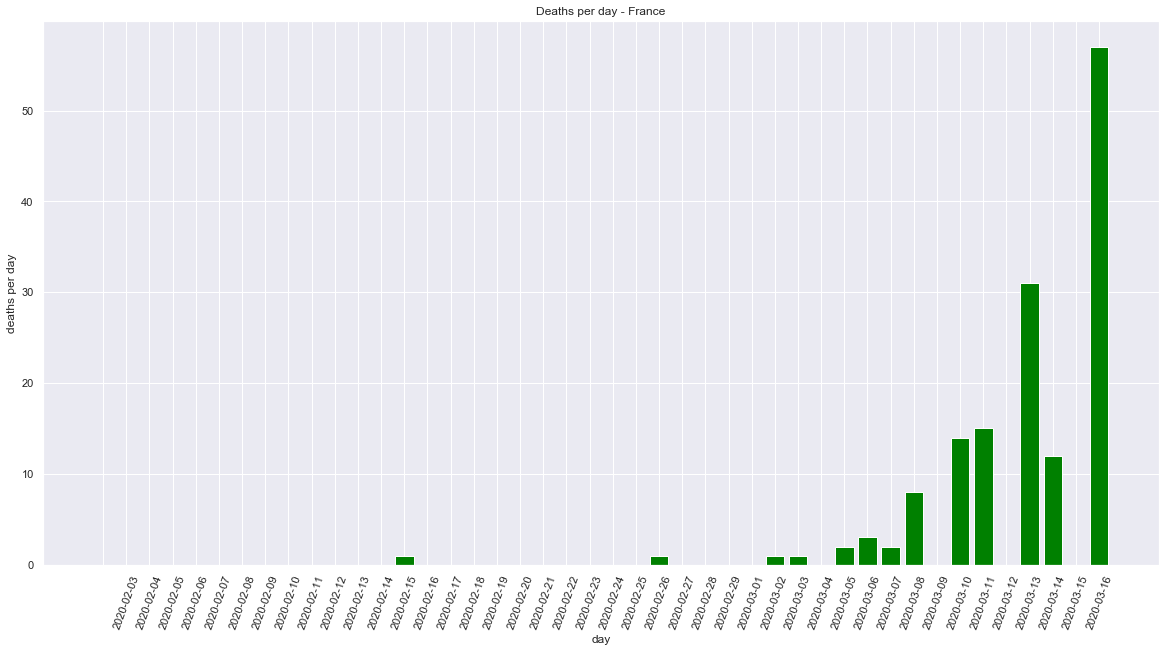

In [41]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Deaths per day - France")
ax.set_xlabel("day")
ax.set_ylabel("deaths per day");
ax.set_xticks(deaths_per_day_fr.index)
ax.set_xticklabels(deaths_per_day_fr.index[1:].format('%Y-%m-%d'), rotation=70)
plt.bar(dates_array[1:], deaths_per_day_array_fr, color='green')

### Cumulative incidence

In [42]:
cumulative_incidence_fr = ( confirmed_infections_fr.last('1D') / population_fr) * 1000
print("France's cumulative incidence = %.2f"%cumulative_incidence_fr)

France's cumulative incidence = 0.10


### Case fatality

In [43]:
last_infections_fr = confirmed_infections_fr[confirmed_infections_fr.size - 1]
last_deaths_fr = deaths_fr[deaths_fr.size - 1]
last_day = dates_index[dates_index.size - 1]
last_case_fatality_fr = (last_deaths_fr / last_infections_fr) * 100 
print("Last report day: {0:4s} \ndeaths: {1:5d}; cumulative confirmed infections: {2:5d}; case fatality {3:5.2f} %".format(last_day.strftime('%Y-%m-%d'), last_deaths_fr, last_infections_fr, last_case_fatality_fr))  

Last report day: 2020-03-16 
deaths:   148; cumulative confirmed infections:  6633; case fatality  2.23 %


In [44]:
cf_array_fr = [(deaths_fr[d] / confirmed_infections_fr[d]) * 100 for d in range(dates_index.size)]
cf_fr = pd.Series(cf_array_fr, index=dates_index)

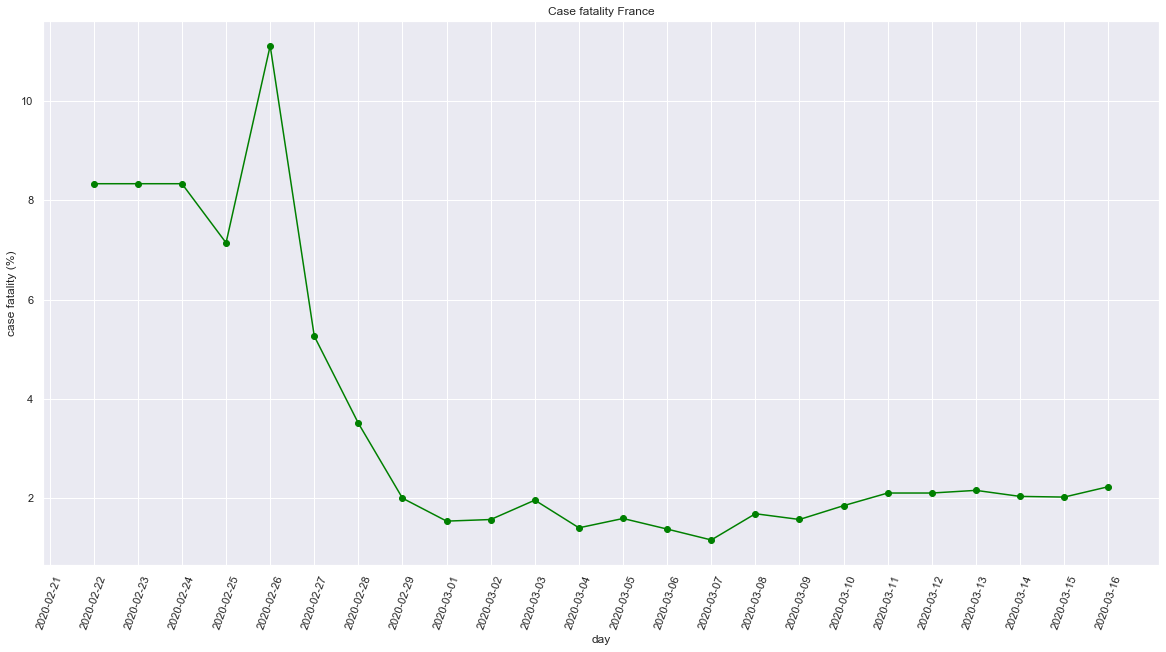

In [45]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Case fatality France")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(cf_fr.index)
ax.set_xticklabels(cf_fr.index[1:].format('%Y-%m-%d'), rotation=70)
plt.plot(cf_fr['2020-02-22':], color='green', marker='o')

***
## Spain

In [46]:
population_es = population[population['country_code'] == 'ES']['total'].values
print("Spain's population (2019) = %d"%population_es)

Spain's population (2019) = 46937060


In [47]:
beds_es = beds[beds['country_code'] == 'ES']['2017'].values
print("Spain's public and private health care facilities, available beds in 2017 = %d"%beds_es)

Spain's public and private health care facilities, available beds in 2017 = 138511


In [48]:
people_per_bed_es =  population_es / beds_es 
print("Number of persons per bed = %.0f"%people_per_bed_es)

Number of persons per bed = 339


### Cumulative confirmed infections
The number of infected individuals each day is the sum of all the confirmed infected individuals from the beginning up to that day.

In [49]:
confirmed_dataset_es = confirmed_dataset[confirmed_dataset['Country/Region'] == 'Spain'] 
confirmed_dataset_values_es = [confirmed for confirmed in confirmed_dataset_es.values[0][start_date_index:]] 
confirmed_infections_es = pd.Series(confirmed_dataset_values_es, index=dates_index)
confirmed_infections_es['2020-03-05':] 

2020-03-05     259
2020-03-06     400
2020-03-07     500
2020-03-08     673
2020-03-09    1073
2020-03-10    1695
2020-03-11    2277
2020-03-12    2277
2020-03-13    5232
2020-03-14    6391
2020-03-15    7798
2020-03-16    9942
dtype: int64

### Confirmed infections per day
The confirmed infections per day are computed from the cumulative confirmed infections by computing the difference between two consecutive days.

In [50]:
confirmed_per_day_array_es = [confirmed_infections_es[d++1] - confirmed_infections_es[d] for d in range(dates_index.size - 1)]
confirmed_per_day_es = pd.Series(confirmed_per_day_array_es, index=dates_index[1:])
confirmed_per_day_es['2020-03-05':]

2020-03-05      37
2020-03-06     141
2020-03-07     100
2020-03-08     173
2020-03-09     400
2020-03-10     622
2020-03-11     582
2020-03-12       0
2020-03-13    2955
2020-03-14    1159
2020-03-15    1407
2020-03-16    2144
dtype: int64

<BarContainer object of 44 artists>

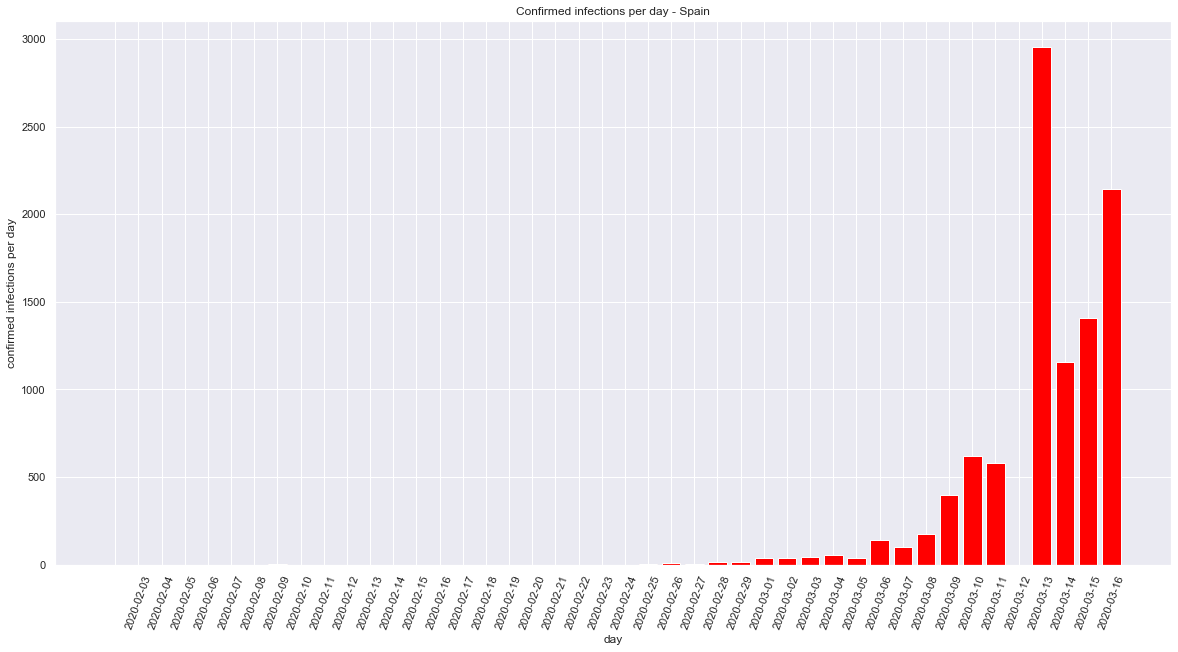

In [51]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Spain")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(confirmed_per_day_es.index)
ax.set_xticklabels(confirmed_per_day_es.index[1:].format('%Y-%m-%d'), rotation=70)
plt.bar(dates_array[1:], confirmed_per_day_array_es, color='red')

### Cumulative deaths
The number of deaths each day is the sum of the deaths from the beginning up to that day.

In [52]:
deaths_dataset_es = deaths_dataset[deaths_dataset['Country/Region'] == 'Spain']
deaths_dataset_values_es = [death for death in deaths_dataset_es.values[0][start_date_index:]]
deaths_es = pd.Series(deaths_dataset_values_es, index=dates_index)
deaths_es['2020-03-05':]

2020-03-05      3
2020-03-06      5
2020-03-07     10
2020-03-08     17
2020-03-09     28
2020-03-10     35
2020-03-11     54
2020-03-12     55
2020-03-13    133
2020-03-14    195
2020-03-15    289
2020-03-16    342
dtype: int64

### Deaths per day
The deaths per day are computed from the cumulative deaths by computing the difference between two consecutive days.

In [53]:
deaths_per_day_array_es = [deaths_es[d++1] - deaths_es[d] for d in range(dates_index.size - 1)]
deaths_per_day_es = pd.Series(deaths_per_day_array_es, index=dates_index[1:])
deaths_per_day_es['2020-03-05':]

2020-03-05     1
2020-03-06     2
2020-03-07     5
2020-03-08     7
2020-03-09    11
2020-03-10     7
2020-03-11    19
2020-03-12     1
2020-03-13    78
2020-03-14    62
2020-03-15    94
2020-03-16    53
dtype: int64

<BarContainer object of 44 artists>

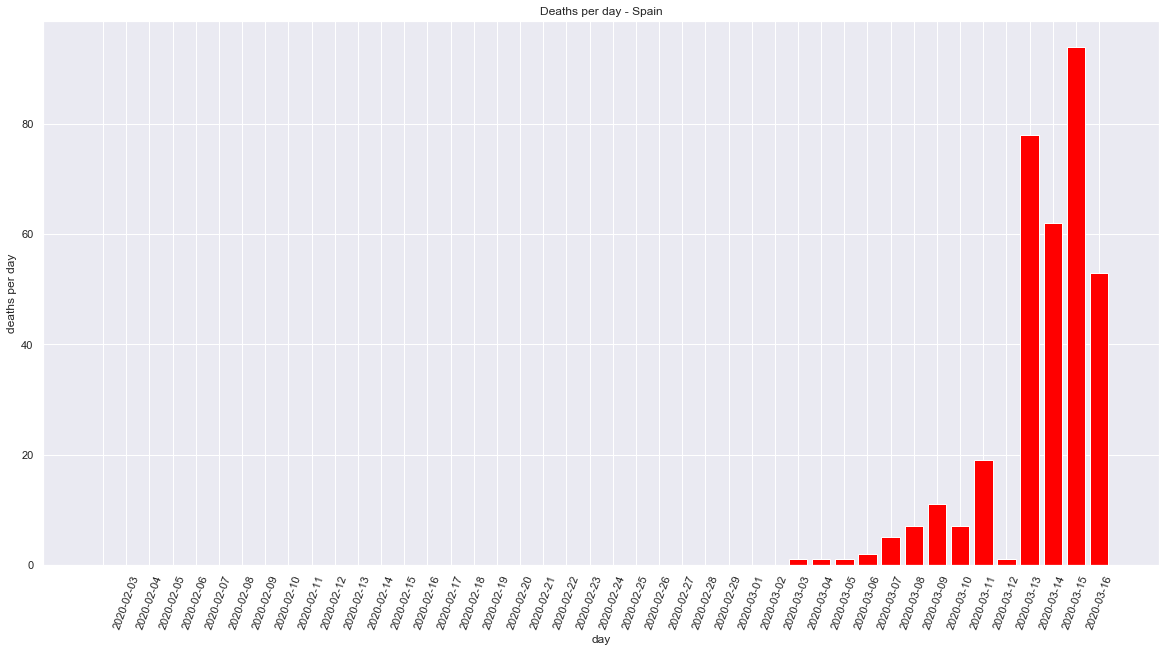

In [54]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Deaths per day - Spain")
ax.set_xlabel("day")
ax.set_ylabel("deaths per day");
ax.set_xticks(deaths_per_day_es.index)
ax.set_xticklabels(deaths_per_day_es.index[1:].format('%Y-%m-%d'), rotation=70)
plt.bar(dates_array[1:], deaths_per_day_array_es, color='red')

### Cumulative incidence

In [55]:
cumulative_incidence_es = ( confirmed_infections_es.last('1D') / population_es) * 1000
print("Spain's cumulative incidence = %.2f"%cumulative_incidence_es)

Spain's cumulative incidence = 0.21


### Case fatality

In [56]:
last_infections_es = confirmed_infections_es[confirmed_infections_es.size - 1]
last_deaths_es = deaths_es[deaths_es.size - 1]
last_day = dates_index[dates_index.size - 1]
last_case_fatality_es = (last_deaths_es / last_infections_es) * 100 
print("Last report day: {0:4s} \ndeaths: {1:5d}; cumulative confirmed infections: {2:5d}; case fatality {3:5.2f} %".format(last_day.strftime('%Y-%m-%d'), last_deaths_es, last_infections_es, last_case_fatality_es))  

Last report day: 2020-03-16 
deaths:   342; cumulative confirmed infections:  9942; case fatality  3.44 %


In [57]:
cf_array_es = [(deaths_es[d] / confirmed_infections_es[d]) * 100 for d in range(dates_index.size)]
cf_es = pd.Series(cf_array_es, index=dates_index)

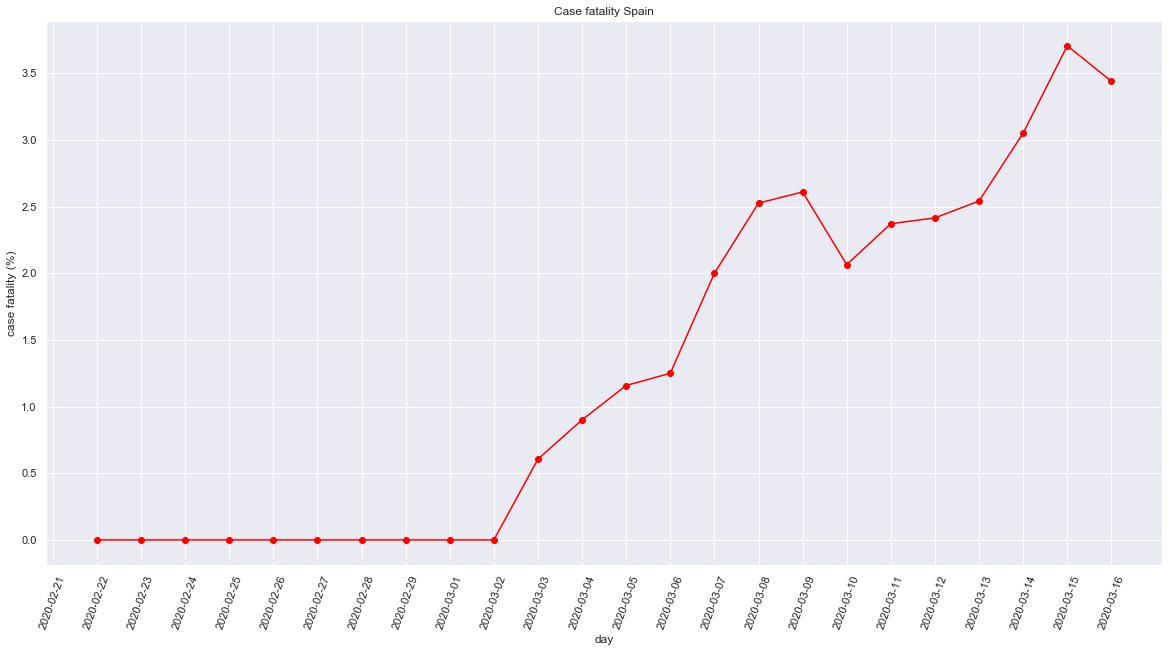

In [58]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Case fatality Spain")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(cf_es.index)
ax.set_xticklabels(cf_es.index[1:].format('%Y-%m-%d'), rotation=70)
plt.plot(cf_es['2020-02-22':], color='red', marker='o')

***
## Comparisons
Merged graphs for Italy, Germany, France and Spain

### Cumulative confirmed infections

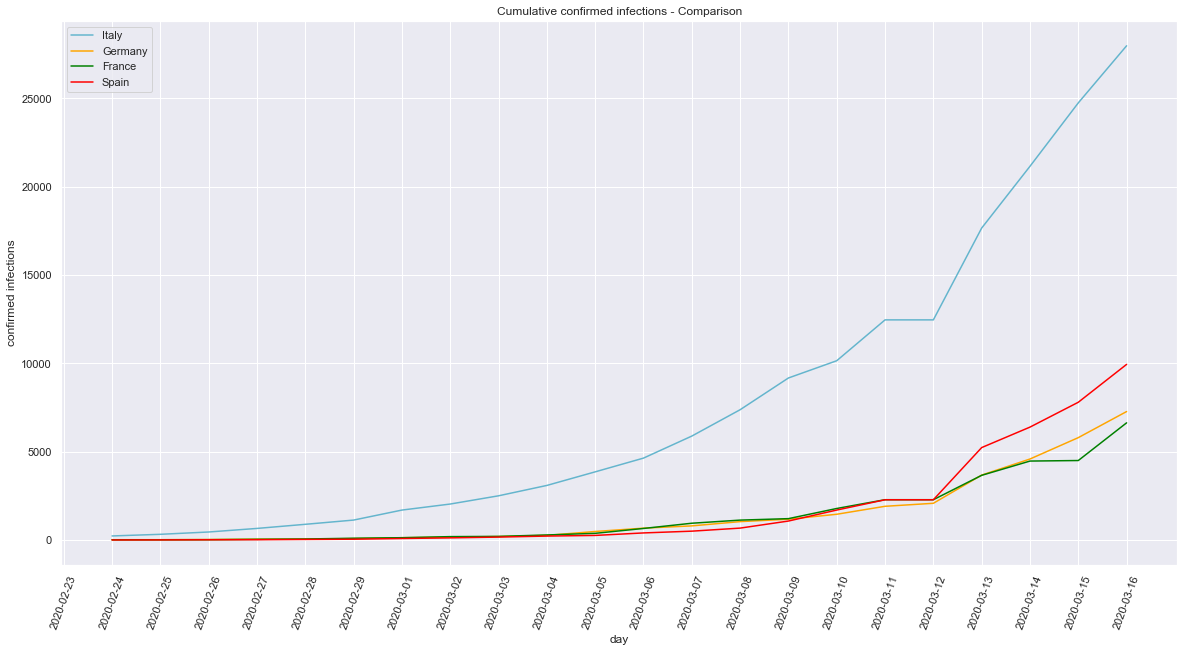

In [59]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Cumulative confirmed infections - Comparison")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections");
ax.set_xticks(confirmed_infections_it.index)
ax.set_xticklabels(confirmed_infections_it.index[1:].format('%Y-%m-%d'), rotation=70)
pi_it, = plt.plot(confirmed_infections_it['2020-02-24':], label='Italy', color='c')
pi_de, = plt.plot(confirmed_infections_de['2020-02-24':], label='Germany', color='orange')
pi_fr, = plt.plot(confirmed_infections_fr['2020-02-24':], label='France', color='green')
pi_es, = plt.plot(confirmed_infections_es['2020-02-24':], label='Spain', color='red')
plt.legend(handles=[pi_it, pi_de, pi_fr, pi_es])

### Cumulative deaths

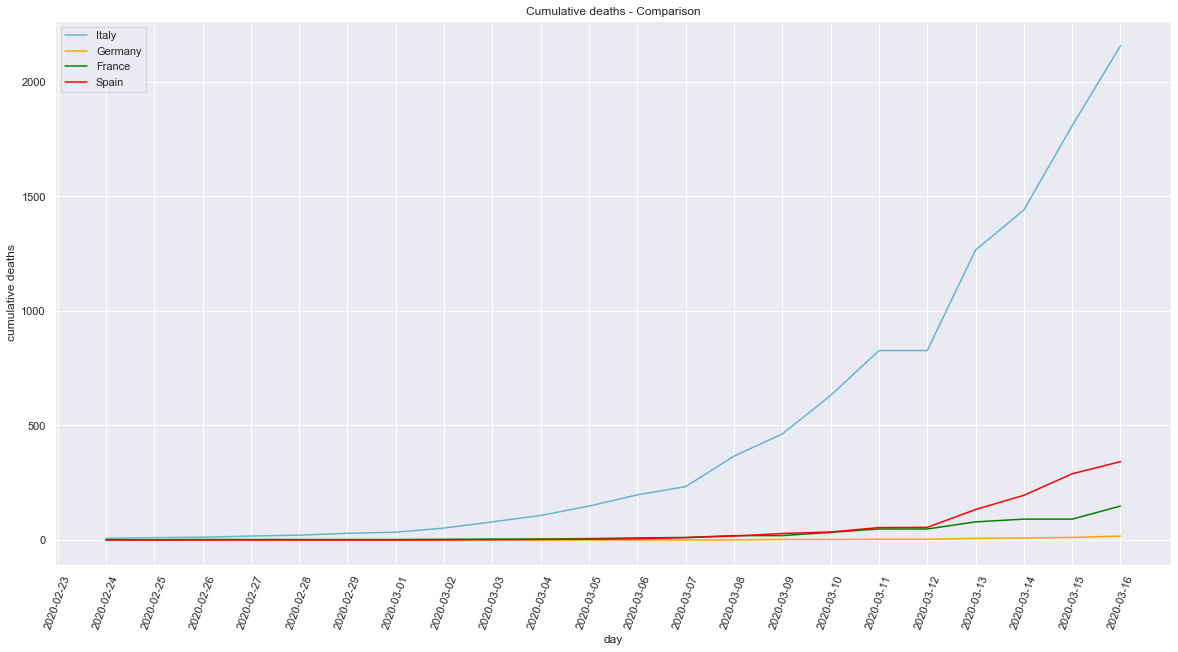

In [60]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Cumulative deaths - Comparison")
ax.set_xlabel("day")
ax.set_ylabel("cumulative deaths");
ax.set_xticks(deaths_it.index)
ax.set_xticklabels(deaths_it.index[1:].format('%Y-%m-%d'), rotation=70)
pd_it, = plt.plot(deaths_it['2020-02-24':], label='Italy', color='c')
pd_de, = plt.plot(deaths_de['2020-02-24':], label='Germany', color='orange')
pd_fr, = plt.plot(deaths_fr['2020-02-24':], label='France', color='green')
pd_es, = plt.plot(deaths_es['2020-02-24':], label='Spain', color='red')
plt.legend(handles=[pd_it, pd_de, pd_fr, pd_es])

### Confirmed infections per day

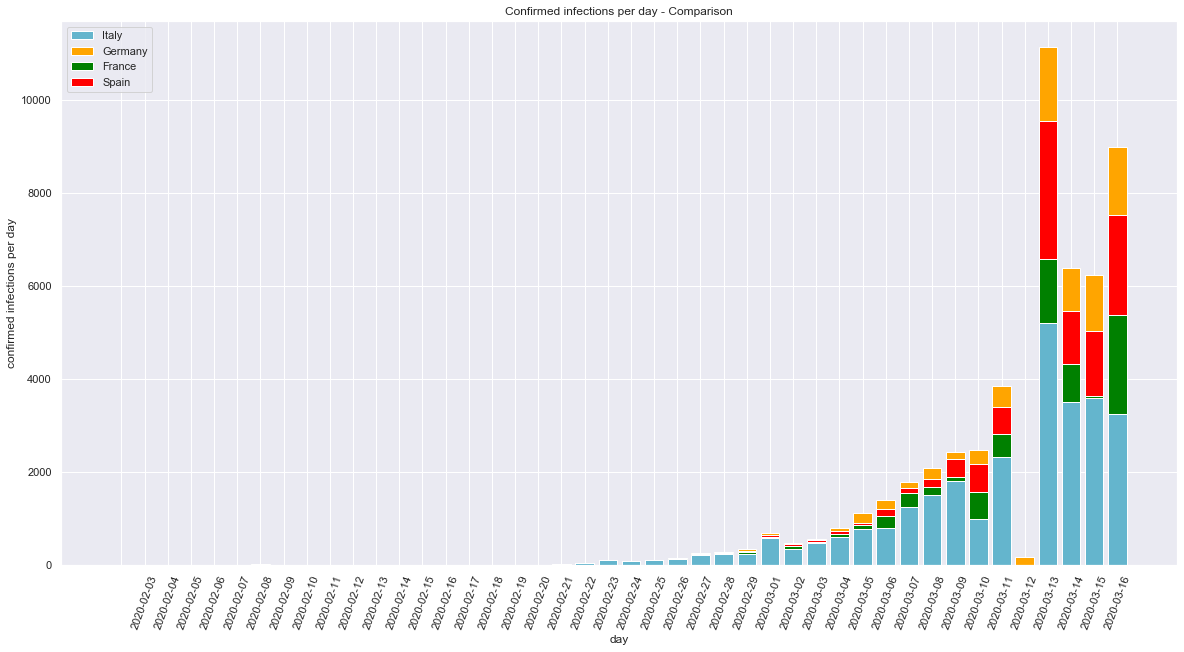

In [61]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Comparison")
ax.set_xlabel("day")
ax.set_ylabel('confirmed infections per day')
ax.set_xticks(confirmed_per_day_it.index)
ax.set_xticklabels(confirmed_per_day_it.index[1:].format('%Y-%m-%d'), rotation=70)
pi_it = plt.bar(dates_array[1:], confirmed_per_day_array_it, color='c')
pi_fr = plt.bar(dates_array[1:], confirmed_per_day_array_fr, bottom=confirmed_per_day_array_it, color='green')
len_array = len(confirmed_per_day_array_it)
bar_base = [confirmed_per_day_array_it[d] + confirmed_per_day_array_fr[d] for d in range(len_array)]
pi_es = plt.bar(dates_array[1:], confirmed_per_day_array_es, bottom = bar_base, color='red')
bar_base = [bar_base[d] + confirmed_per_day_array_es[d] for d in range(len_array)] # bottom update
pi_de = plt.bar(dates_array[1:], confirmed_per_day_array_de, bottom = bar_base, color='orange')
plt.legend((pi_it, pi_de, pi_fr, pi_es), ['Italy', 'Germany', 'France', 'Spain'], loc='upper left')
#plt.savefig('deaths-per-day.png')

### Deaths per day

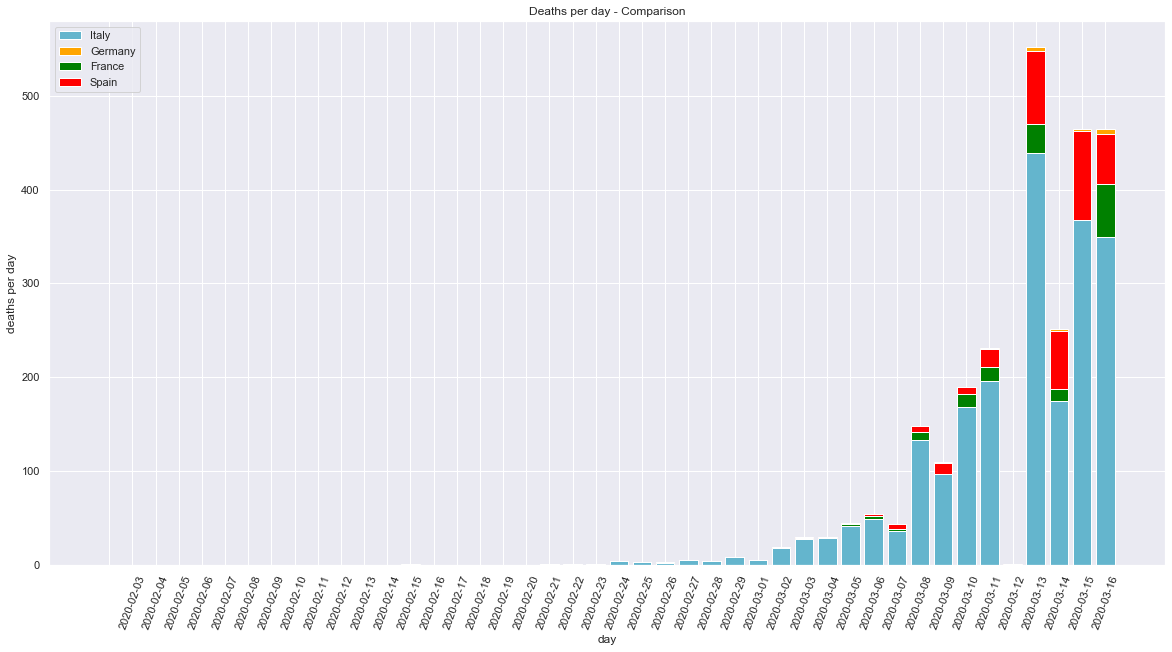

In [62]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Deaths per day - Comparison")
ax.set_xlabel("day")
ax.set_ylabel('deaths per day')
ax.set_xticks(confirmed_per_day_it.index)
ax.set_xticklabels(confirmed_per_day_it.index[1:].format('%Y-%m-%d'), rotation=70)
pi = plt.bar(dates_array[1:], deaths_per_day_array_it, color='c')
pf = plt.bar(dates_array[1:], deaths_per_day_array_fr, bottom = deaths_per_day_array_it, color='green')
len_array = len(deaths_per_day_array_it)
bar_base = [deaths_per_day_array_it[d] + deaths_per_day_array_fr[d] for d in range(len_array)]
ps = plt.bar(dates_array[1:], deaths_per_day_array_es, bottom = bar_base, color='red')
bar_base = [bar_base[d] + deaths_per_day_array_es[d] for d in range(len_array)]
pg = plt.bar(dates_array[1:], deaths_per_day_array_de, bottom = bar_base, color='orange')
plt.legend((pi[0], pg[0], pf[0], ps[0]), ['Italy', 'Germany', 'France', 'Spain'], loc='upper left')

### Case fatality

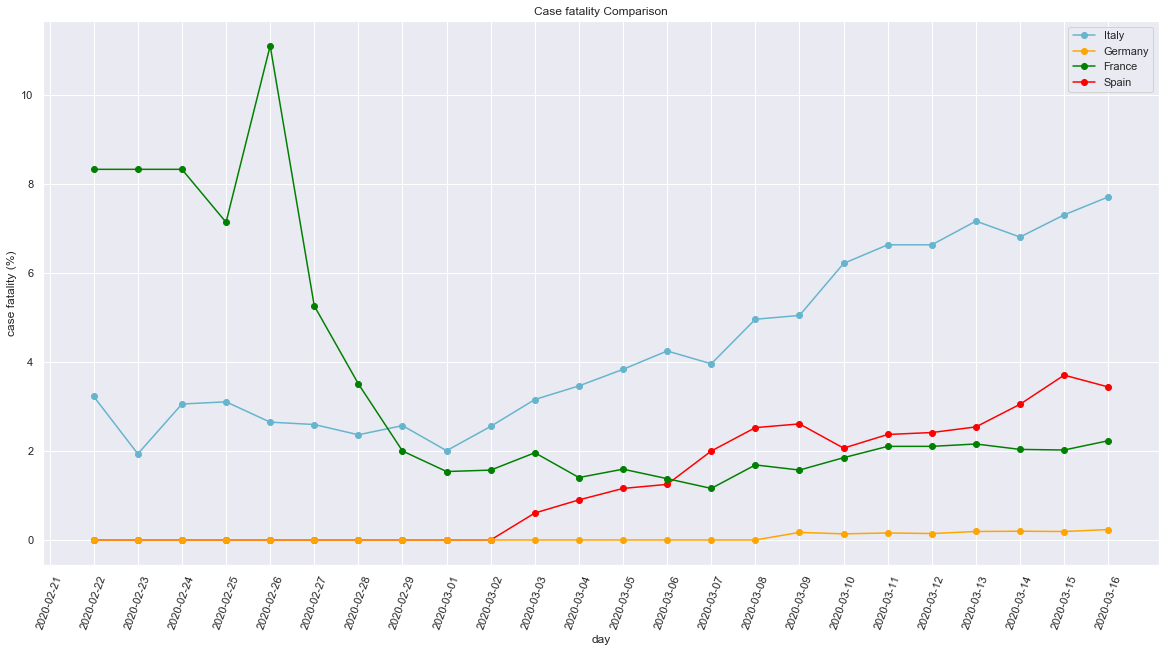

In [63]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Case fatality Comparison")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(cf_it.index)
ax.set_xticklabels(cf_it.index[1:].format('%Y-%m-%d'), rotation=70)
pcf_it = plt.plot(cf_it['2020-02-22':], color='c', marker='o')
pcf_es = plt.plot(cf_es['2020-02-22':], color='red', marker='o')
pcf_fr = plt.plot(cf_fr['2020-02-22':], color='green', marker='o')
pcf_de = plt.plot(cf_de['2020-02-22':], color='orange', marker='o')
plt.legend((pcf_it[0], pcf_de[0], pcf_fr[0], pcf_es[0]), ['Italy', 'Germany', 'France', 'Spain'])
#plt.savefig('case_fatalities.png')